# RI GW

## Abstract 

Here we present a reference implementation of a GW class with the option of applying resolution-of-identity (JK with Coulomb metric, available for both self-energy and W) as well as SPA approximation when evaluating W. The class will be further extended to incorporate GW@DFT and spin polarization.

1. Bruneval, F., Rangel, T., Hamed, S. M., Shao, M., Yang, C., & Neaton, J. B. (2016). molgw 1: Many-body perturbation theory software for atoms, molecules, and clusters. Computer Physics Communications, 208, 149–161. https://doi.org/10.1016/J.CPC.2016.06.019

2. van Setten, M. J., Weigend, F., & Evers, F. (2013). The GW -Method for Quantum Chemistry Applications: Theory and Implementation. Journal of Chemical Theory and Computation, 9(1), 232–246. https://doi.org/10.1021/ct300648t

In [1]:
import psi4
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
h2o = psi4.geometry("""O   0.000000000000  -0.143225816552   0.000000000000 
                       H   1.638036840407   1.136548822547  -0.000000000000
                       H  -1.638036840407   1.136548822547  -0.000000000000
                       symmetry c1
                       units bohr
""")

psi4.set_options({'basis': 'aug-cc-pvdz', 'd_convergence' : 1e-7,'scf_type' : 'direct'})
#psi4.set_options({'basis': 'aug-cc-pvdz', 'd_convergence' : 1e-7,'scf_type' : 'df', 'ints_tolerance' : 1.0E-10})


psi4.set_memory('2 GB')
psi4.set_output_file('h2o_accpvdz_rigw.out')

# Get the SCF wavefunction & energies
scf_e, scf_wfn = psi4.energy('hf', return_wfn=True)

print("SCF energy is %16.10f" % scf_e)

SCF energy is   -76.0033540582


In [23]:
# GW implementation will be folded into a standalone class that uses molecule and wave function data from Psi4

class GW:
    
    def __init__(self, wfn, mol, gw_par):
        
        # wfn - Psi4 w.f. object from SCF calculation
        # mol - Psi4 molecule object
        # gw_par - is a dictionary with GW calculation parameters
        #          such as the number of states or the number of 
        #          omega sampling points
        
        self.scf_wfn = wfn
        self.mol = mol
        
        self._init_sys_params() # sets some basic system parameters
        
        # Determine if we are doing RI
        
        self.do_ri = True if not 'do_ri' in gw_par.keys() else gw_par['do_ri']
        
        if self.do_ri:
            self._gen_ri_ints()     # generates integrals for RI-GW and
            # RI integrals are now available in self.nmR
        else:
            self._transform_eri()
            
        #self._calculate_W(gw_par) # this will produce RPA excitation energies and X + Y
        self._calculate_W_SPA(gw_par) # this will produce RPA excitation energies and X + Y
        
        # set GW calculation parameters
        
        # parameters of the self-energy calculation
        nomega_sigma =  501 if not 'nomega_sigma' in gw_par.keys() else gw_par['nomega_sigma']
        step_sigma = 0.01 if not 'step_sigma' in gw_par.keys() else  gw_par['step_sigma']
        
        # Quasi-particle states 
        self.no_qp = self.nocc if not 'no_qp' in gw_par.keys() else gw_par['no_qp'] # Number of hole states 
        self.nv_qp = 0 if not 'nv_qp' in gw_par.keys() else gw_par['nv_qp']             # Number of particle states
        self.eta = 1e-3  # Default eta value as recommended by F. Bruneval
        
        # Quick sanity check
        
        assert self.no_qp <= self.nocc and self.nv_qp <= self.nvir

        # create an array of sampling frequencies similar to MolGW

        nomega_grid = nomega_sigma // 2 # note this is a truncation (aka integer) division
        omega_grid = np.array(range(-nomega_grid, nomega_grid + 1)) * step_sigma
        
        # sampling energies for all the states so we could calculate the self-energy matrix (broadcasting)

        omega_grid_all = omega_grid + self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp].reshape((-1, 1))
        assert omega_grid_all.shape == (self.no_qp + self.nv_qp, 2*nomega_grid + 1)
        
        Sigma_c_grid = self._calculate_iGW(omega_grid_all) # self-energy matrix
        
        # Apply solvers; Similar to MolGW - linear & graphic solutions

        print("Performing one-shot G0W0")
        
        qp_molgw_lin_ = np.zeros(self.no_qp + self.nv_qp)

        # Calculate pole strengths by performing numerical derivative on the omega grid

        zz = np.real(Sigma_c_grid[:, nomega_grid + 1] - Sigma_c_grid[:, nomega_grid - 1]) / (omega_grid[nomega_grid + 1] - omega_grid[nomega_grid - 1])
        zz = 1. / (1. - zz)
        zz[zz <= 0.0] = 0.0
        zz[zz >= 1.0] = 1.0
        
        qp_molgw_lin_ = self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp] + zz * np.real(Sigma_c_grid[:, nomega_grid])
        
        print("Perfoming graphic solution of the inverse Dyson equation")

        # both rhs and lhs of the QP equation have been calculated above
        
        qp_molgw_graph_ = np.copy(self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp])
        zz_graph = np.zeros(self.no_qp + self.nv_qp)
        
        for state in range(self.no_qp + self.nv_qp):
            z , e = self._find_fixed_point(omega_grid_all[state], np.real(Sigma_c_grid[state, :]) + self.eps[state + self.nocc - self.no_qp])
            if z[0] < 1e-6:
                print("Graphical solver failed for state %d" % (state + 1))
            # Do nothing since the array cell already contains HF orbital energy
            else:
                qp_molgw_graph_[state] = e[0]
                zz_graph[state] = z[0]
                
        self.zz = np.copy(zz)
        self.qp_molgw_lin_ = np.copy(qp_molgw_lin_)
        self.qp_molgw_graph_ = np.copy(qp_molgw_graph_)
                
        print("Done!")
        
    def print_summary(self):
        
        Ha2eV = 27.21138505
        
        print("E^lin, eV  E^graph, eV  Z ")
        for i in range(self.no_qp + self.nv_qp):
            print("%13.6f  %13.6f  %13.6f" % (self.qp_molgw_lin_[i]*Ha2eV, self.qp_molgw_graph_[i]*Ha2eV, self.zz[i]))
    
                
    def _init_sys_params(self):
        
        self.nocc = self.scf_wfn.nalpha()
        self.nbf = self.scf_wfn.nmo()
        self.nvir = self.nbf - self.nocc
        self.C = self.scf_wfn.Ca()
        
        self.Cocc = self.scf_wfn.Ca_subset("AO", "OCC")
        self.Cvirt = self.scf_wfn.Ca_subset("AO", "VIR")
        
        self.eps = np.asarray(self.scf_wfn.epsilon_a())
        
        # print a quick summary
        print("Number of basis functions: ", self.nbf)
        print("occ/virt: %d/%d" % (self.nocc, self.nvir))
    
    def _transform_eri(self):
        
        Co = self.Cocc
        C = self.C
        
        mints = psi4.core.MintsHelper(self.scf_wfn.basisset())
        self.MO = np.asarray(mints.mo_eri(Co, C, C, C))
        
    def _gen_ri_ints(self):
        
        # MO coefficients
        C = np.asarray(self.C)
        
        # Extract basis set from the wfn object
        orb = self.scf_wfn.basisset()
        
        # Build auxiliary basis set
        aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "JKFIT", orb.name())
        
        # From Psi4 doc as of March, 2019 (http://www.psicode.org/psi4manual/1.2/psi4api.html#psi4.core.BasisSet.zero_ao_basis_set): 
        # Returns a BasisSet object that actually has a single s-function at 
        # the origin with an exponent of 0.0 and contraction of 1.0.
        zero_bas = psi4.core.BasisSet.zero_ao_basis_set()
        
        # Create a MintsHelper Instance
        mints = psi4.core.MintsHelper(orb)

        # Build (pq|P) raw 3-index ERIs, dimension (nbf, nbf, Naux, 1)
        pqP = mints.ao_eri(orb, orb, aux, zero_bas)

        # Build and invert the metric
        metric = mints.ao_eri(zero_bas, aux, zero_bas, aux)
        metric.power(-0.5, 1.e-14)
        
        # Remove the dimensions of size 1
        pqP = np.squeeze(pqP)
        metric = np.squeeze(metric)

        # Transform (pq|P) to obtain (nm|P) in molecular orbital basis
        nmP = np.einsum("pn, qm, pqR-> nmR", C, C, pqP)
        
        # Contract with the inverse square root of the metric tensor
        self.nmR = np.einsum( "nmP, PR-> nmR", nmP, metric)
        
        print("Auxiliary basis set has been generated!")
        print("Number of auxiliary basis functions: ", self.nmR.shape[2])
    
    
    def _calculate_W_SPA(self, gw_par):
        # spa_onset - is the orbital # starting from which SPA will be employed, 
        # i.e. spa_onset - 1 is the index of the last virtual active in 
        # RPA calculation
        
        spa_onset = self.nbf if not 'spa_onset' in gw_par.keys() else gw_par['spa_onset']
        spa_alpha = 1.5 if not 'spa_alpha' in gw_par.keys() else gw_par['spa_alpha']
        
        assert (spa_onset >= self.nocc) and (spa_alpha >= 0.0)
        
        nocc = self.nocc
        nvir = self.nvir
        nbf = self.nbf
        
        if spa_onset < nbf:
            # The actual number of virtual orbitals is reduced
            nvir = spa_onset  - nocc # if spa_onset is nocc (i.e. LUMO) => there is no virtual orbitals in the RPA
        else:
            spa_onset = nbf # for extra safety so that nothing fails if spa_onset is too large; the last virtual is nbf - 1 
            
        print("Number of virtual orbitals in RPA: %d" % (nvir))
        
        # Diagonal \epsilon_a - \epsilon_i
        eps_diag = self.eps[nocc:nocc + nvir].reshape(-1, 1) - self.eps[:nocc]
        assert eps_diag.shape == (nvir, nocc)
        
        # Diagonal orbital difference matrix for SPA
        eps_spa_diag = self.eps[spa_onset:].reshape(-1, 1) - self.eps[:nocc]
        assert eps_spa_diag.shape == (nbf - nvir - nocc, nocc)
        
        # A^{+} + B^{+}
        ApB = np.zeros((nocc, nvir, nocc, nvir))
        ApB_spa_diag = np.zeros((nocc, nbf - nvir - nocc))
        if self.do_ri:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * np.einsum("iaQ, jbQ->iajb", self.nmR[:nocc, nocc:nocc+nvir], self.nmR[:nocc, nocc:nocc+nvir])
        else:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * self.MO[:nocc, nocc:nocc + nvir, :nocc, nocc:nocc + nvir ]
            
        if spa_onset < nbf:
            # calculate ApB_spa_diag
            if self.do_ri:
                ApB_spa_diag = spa_alpha * ( eps_spa_diag.T + 4. * np.einsum("iaQ, iaQ->ia", self.nmR[:nocc, spa_onset:], self.nmR[:nocc, spa_onset:]))
            else:
                ApB_spa_diag = spa_alpha * (eps_spa_diag.T + 4. * np.einsum("iaia->ia", self.MO[:nocc, spa_onset:, :nocc, spa_onset: ])) # not sure if this is 100% correct
                    
                
        ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
        # since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

        # Diagonal of  A^{+} - B^{+}
        AmB_diag = eps_diag.T.reshape((1, -1))
        AmB_diag = np.diag(AmB_diag[0,:])
        
        # Reshape the ApB_spa_diag as well
        AmB_spa_diag = spa_alpha * eps_spa_diag.T.reshape((1, -1))
        #AmB_spa_diag = np.diag(AmB_spa_diag[0,:])
        ApB_spa_diag = ApB_spa_diag.reshape((1, -1))
        

        # Form C matrix (RPA eigenvalue problem)
        C_ = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))
        
        # Solve for the excitation energies and calculate X + Y eigenvectors
        
        omega2, Z = np.linalg.eigh(C_)
        self.omega_s = np.sqrt(omega2)
        self.xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(self.omega_s)))
        
        if spa_onset < nbf:
            omega_s_spa = np.sqrt(ApB_spa_diag * AmB_spa_diag)
            #print(omega_s_spa.shape)
            #print(np.sqrt(np.diag(AmB_spa_diag[0,:])).shape)
            #print(np.eye(nocc * (nbf - nocc - nvir)).shape)
            #print(np.diag(1./np.sqrt(omega_s_spa)).shape)
            xpy_spa = np.einsum("ij,jk,kl->il", np.sqrt(np.diag(AmB_spa_diag[0,:])), np.eye(nocc * (nbf - nocc - nvir)), np.diag(1./np.sqrt(omega_s_spa[0,:])))
            # The trickiest part is the eigenvectors since the index spaces should be 
            # aligned; Here we need to do the following:
            # 1. Stretch xpy array such that its shape = (nocc * (nbf - nocc), nocc * (nbf - nocc))
            # 2. Copy the eigenvectors adding 0 in place of excitations excluded via SPA
            # 3. Add an apropriate number of xpy_spa padding them with zero at the indexes corresponding
            #    to excitations excluded from SPA
            
            xpy_tmp = np.zeros((nocc * (nbf - nocc), nocc * (nbf - nocc)))
            
            # Merge non-SPA eigenvectors first
            
            nvir_spa = nbf - nocc - nvir
            
            for i in range(len(self.omega_s)):
                for j in range(nocc):
                    xpy_tmp[j * (nbf - nocc) : j * (nbf - nocc) + nvir , i] = self.xpy[j * nvir: (j+1) * nvir, i] 
                    
            # Now merge SPA vectors
            
            for i in range(len(omega_s_spa)):
                for j in range(nocc):
                    xpy_tmp[ j * (nbf - nocc) + nvir : (j + 1) * (nbf - nocc)  , i + len(self.omega_s)] = xpy_spa[j * nvir_spa: (j+1) * nvir_spa, i] 
                    
            # Replace xpy with xpy_tmp and update the list of excitation energies accordingly
            
            self.xpy = np.copy(xpy_tmp)
            self.omega_s = np.hstack((self.omega_s, omega_s_spa[0,:]))

        
    def _calculate_W(self, gw_par):
        
                
        nocc = self.nocc
        nvir = self.nvir
        
        # Diagonal \epsilon_a - \epsilon_i
        eps_diag = self.eps[nocc:].reshape(-1, 1) - self.eps[:nocc]
        assert eps_diag.shape == (nvir, nocc)
        
        # A^{+} + B^{+}
        ApB = np.zeros((nocc, nvir, nocc, nvir))
        if self.do_ri:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * np.einsum("iaQ, jbQ->iajb", self.nmR[:nocc, nocc:], self.nmR[:nocc, nocc:])
        else:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * self.MO[:nocc, nocc:, :nocc, nocc: ]
        
                  
        
        ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
        # since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

        # Diagonal of  A^{+} - B^{+}
        AmB_diag = eps_diag.T.reshape((1, -1))
        AmB_diag = np.diag(AmB_diag[0,:])

        assert AmB_diag.shape == ApB.shape

        # Form C matrix (as one usually does when solving RPA eigenvalue problem)
        C_ = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))
        
        # Solve for the excitation energies and calculate X + Y eigenvectors
        
        omega2, Z = np.linalg.eigh(C_)
        self.omega_s = np.sqrt(omega2)
        self.xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(self.omega_s)))
        
    def _calculate_iGW(self, omega_grid_all):
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        # Self-energy denominators; those are of two kinds

        Dis = -eps[:nocc].reshape((-1, 1)) + self.omega_s
        Das = -eps[nocc:].reshape((-1, 1)) - self.omega_s 
        
        # Omega tensors; This will be refactored to improve memory efficiency
        i_rtia = np.zeros((nbf,nbf, nocc, nvir))
        if self.do_ri:
            i_rtia = np.einsum("iaQ, rtQ ->rtia", self.nmR[:nocc, nocc:, :], self.nmR) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
        else:
            i_rtia = np.einsum("iart->rtia", self.MO[:,nocc:,:,:]) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
            
        omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, self.xpy)
        
        #Calculate denominators
        
        Dis_ = Dis + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) - 1.j*self.eta
        Das_ = Das + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) + 1.j*self.eta

        # self-energy matrix (with the shape (no_qp + nv_qp, 2*nomega_grid + 1))

        # Contribution due to occupied orbitals (note that the shape of the structure of the denominator array is not optimal)
        Sigma_c_grid = np.einsum("kis, klis, kis->kl", omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:], 1./Dis_, omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:])
        # Contribution due to virtuals
        Sigma_c_grid +=  np.einsum("kas, klas, kas->kl", omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:], 1./Das_, omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:])
 
        
        return Sigma_c_grid
    
    
    def _find_fixed_point(self, lhs, rhs):
        # This function returns an array of fixed points and correspoinding pole strengths
        # Its application can be vectorized using strandard NumPy np.vectorize
    
        assert lhs.shape == rhs.shape
    
        # Maximum number of fixed points (same as in MolGW)
        nfp_max = 4
    
        # Pole strength threshold
        pthresh = 1e-5
    
        # Arrays of f.p. energies and  Z
        zfp = np.zeros(nfp_max)
        zfp[:] = -1.0
        efp = np.zeros(nfp_max)
    
        # Auxiliary index array
        idx = np.arange(nfp_max)
    
        n = len(lhs)
        ifixed = 0
        g = rhs - lhs
    
        # loop over grid points excluding the last one
    
        for i in range(n - 1):
            if g[i] * g[i + 1] < 0.0:
                #print("Fixed point found betwenn %13.6f and %13.6f eV! " % (lhs[i] * Ha2eV, lhs[i+1] * Ha2eV))
                z_zero = 1. / ( 1. - ( g[i+1] - g[i] ) / ( lhs[i+1] - lhs[i] ) )
                if z_zero < pthresh:
                    continue
                # Do some bookkeeping; the code looks ugly but that is exactly what F.Bruneval has in MolGW package
            
                if z_zero > zfp[-1]:
                    jfixed = np.min(idx[z_zero > zfp])
                    zfp[jfixed + 1:] = zfp[jfixed:nfp_max - 1]
                    efp[jfixed + 1:] = efp[jfixed:nfp_max - 1]
                    zfp[jfixed] = z_zero
                    # Perfom linear interpolation to find the root
                    zeta = (g[i + 1] - g[i]) / (lhs[i + 1] - lhs[i])
                    efp[jfixed] = lhs[i] - g[i] / zeta
    
        #print("Graphical solver concluded operation")
        return (zfp, efp)




In [17]:
# Quick test for the GW class

gw_par = {'no_qp' : 5, 'nv_qp' : 1, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : False}

gw_h2o_accpvdz = GW(scf_wfn, h2o, gw_par)
gw_h2o_accpvdz.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -548.539374    -547.986942       0.794502
   -32.344115     -31.106137       0.651707
   -17.199686     -17.199453       0.938071
   -14.246618     -14.245208       0.928771
   -12.060278     -12.056027       0.921941
     0.718180       0.718175       0.994145


In [18]:
gw_par = {'no_qp' : 5, 'nv_qp' : 1, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True}

rigw_h2o_accpvdz = GW(scf_wfn, h2o, gw_par)
rigw_h2o_accpvdz.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  150
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -548.539289    -547.986854       0.794502
   -32.343877     -31.105740       0.651667
   -17.198599     -17.198365       0.938078
   -14.245902     -14.244489       0.928775
   -12.059619     -12.055365       0.921945
     0.718147       0.718143       0.994143


In [24]:
# GW class with the new SPA-enabled calculate_W method (SPA will be enabled starting from orbital #7 (LUMO + 2))

gw_par = {'no_qp' : 5, 'nv_qp' : 1, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : False, 'spa_onset' : 7}

gw_h2o_accpvdz = GW(scf_wfn, h2o, gw_par)
gw_h2o_accpvdz.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 2
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -559.330154    -559.326189       0.943804
   -35.092657     -35.108317       0.736476
   -17.457153     -17.457130       0.988255
   -14.989264     -14.989221       0.985092
   -13.319399     -13.319324       0.983257
     0.864673       0.864673       0.999210



```
   1   -560.533646    -0.000000    15.096607     0.794502  -548.539363  -547.986931
   2    -35.249771    -0.000000     4.458541     0.651707   -32.344109   -31.106131
   3    -17.621318    -0.000000     0.449470     0.938071   -17.199683   -17.199450
   4    -15.211273    -0.000000     1.038641     0.928771   -14.246613   -14.245203
   5    -13.614305    -0.000000     1.685604     0.921941   -12.060277   -12.056026
   6      0.873198    -0.000000    -0.155930     0.994145     0.718181     0.718176

```

```
   WITH SPA (2 virtuals in RPA)
   1   -560.533646    -0.000000     1.269277     0.943812  -559.335688  -559.331759
   2    -35.249771    -0.000000     0.213172     0.736479   -35.092774   -35.108421
   3    -17.621318    -0.000000     0.166196     0.988255   -17.457074   -17.457051
   4    -15.211273    -0.000000     0.225294     0.985092   -14.989337   -14.989294
   5    -13.614305    -0.000000     0.300034     0.983257   -13.319294   -13.319219
   6      0.873198    -0.000000    -0.008534     0.999210     0.864670     0.864670
```

In [38]:
# Convergence test for water (noRI; SPA as specified below)
global_gw_par = {'no_qp' : 5, 'nv_qp' : 10, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : False}
ilumo = 5 # Water has five occ. orbitals
ilastvir = 40 # for aug-cc-pvdz
qp_en = np.zeros((global_gw_par['no_qp'] + global_gw_par['nv_qp'], 36))

for i in range(ilumo, ilastvir+1):
    global_gw_par['spa_onset'] = i
    gw_h2o = GW(scf_wfn, h2o, global_gw_par)
    qp_en[:, i - ilumo] = gw_h2o.qp_molgw_graph_


Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 0
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 1
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 2
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 3
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 4
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
Number of basis functions:  41
occ/virt: 5/36
Number of virtual orbitals in RPA: 5
Performing one-shot G0W0
Perfoming graphic solution of the inv

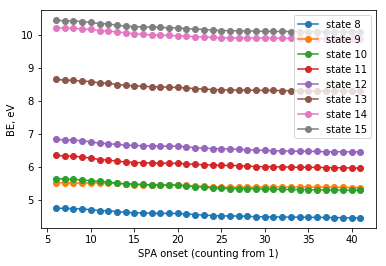

In [41]:
Ha2eV = 27.21138505

x = np.asarray(range(ilumo, ilastvir + 1))
for state in range(7, global_gw_par['no_qp'] + global_gw_par['nv_qp']):
    plt.plot(x + 1, Ha2eV * qp_en[state, :], 'o-', label='state '+str(state + 1) )
    
plt.xlabel('SPA onset (counting from 1)')
plt.ylabel('BE, eV')
plt.legend()


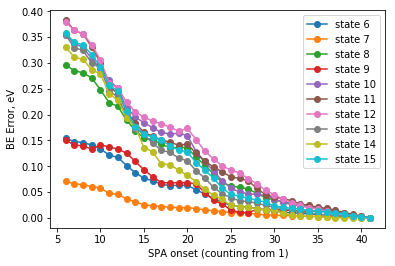

In [45]:
# Some error convergence analysis

qp_en_err = (qp_en.T - qp_en[:,-1].T).T
x = np.asarray(range(ilumo, ilastvir + 1))
for state in range(5, global_gw_par['no_qp'] + global_gw_par['nv_qp']):
    plt.plot(x + 1, Ha2eV * qp_en_err[state, :], 'o-', label='state '+str(state + 1) )
    
plt.xlabel('SPA onset (counting from 1)')
plt.ylabel('BE Error, eV')
plt.legend()

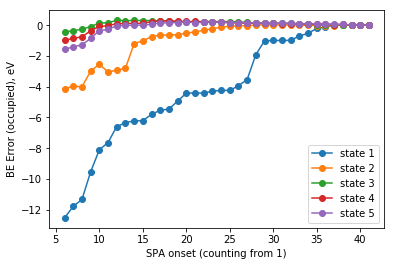

In [46]:
# Error analysis for occupied states

for state in range(0, 5):
    plt.plot(x + 1, Ha2eV * qp_en_err[state, :], 'o-', label='state '+str(state + 1) )
    
plt.xlabel('SPA onset (counting from 1)')
plt.ylabel('BE Error (occupied), eV')
plt.legend()